In [1]:
import pandas as pd
import numpy as np
from time import time

from sklearn.preprocessing import OneHotEncoder
from scipy.stats import entropy

from surprise import Dataset, Reader
from surprise import KNNBaseline
from surprise import NMF as NMF_surprise
from surprise import accuracy as acc 

from myfm import MyFMRegressor, MyFMOrderedProbit

from train_test import get_train_test, convert_df_to_matrix, _read_df_in_format, store_dense_matrix_to_submission, generate_anti_train
from methods import UserAverage, ItemAverage, UserItemAverage, Baseline, ALS, NMF
from utils import stand_norm, de_norm

In [2]:
train_df, test_df = get_train_test('data/data_train.csv', split_num=0)
train_matrix = convert_df_to_matrix(train_df)

In [3]:
full_train_df = _read_df_in_format('data/data_train.csv')

In [18]:
reader = Reader(rating_scale=(1, 5))
train_data = Dataset.load_from_df(train_df, reader)
test_data = Dataset.load_from_df(test_df, reader)

trainset = train_data.build_full_trainset()
testset = test_data.build_full_trainset().build_testset()
anti_trainset = trainset.build_anti_testset()

# Baseline (Averages)

In [10]:
methods = [UserAverage, ItemAverage, UserItemAverage]
for method in methods:
    start_time = time()
    algo = method()
    algo.fit(trainset)
    predictions = algo.test(testset)
    print(f"Method: {method.__name__}, RMSE: {acc.rmse(predictions, False):.4f}, MAE: {acc.mae(predictions, False):.4f}, Time: {time() - start_time:.2f}", end = '\n')

Method: UserAverage, RMSE: 1.0949, MAE: 0.9009, Time: 1.90
Method: ItemAverage, RMSE: 1.0309, MAE: 0.8398, Time: 1.44
Method: UserItemAverage, RMSE: 1.0314, MAE: 0.8482, Time: 2.05


# SVD Baselines

In [6]:
train_matrix_na = train_matrix.copy()
train_matrix_na[train_matrix_na == 0] = np.nan
A, mean, std = stand_norm(train_matrix_na)

In [8]:
A = A.to_numpy()
A[np.isnan(A)] = 0
mask_A = A != 0

In [5]:
bsl = Baseline()
start = time()
X = bsl.IterSVD(A, mask_A, shrinkage=38, n_itr=15)
end = time(); print(f"Time: {end - start:.2f}"); start = time()
U, V = bsl.ALS(X, mask_A, k=3, n_itr=10, lambda_=0.1)
end = time(); print(f"Time: {end - start:.2f}")

Time: 28.26ion is complete.
Initializing ALS
Starting Iterations
Iteration 1		Error after solving for U matrix: 0.8884654604830124		Error after solving for V matrix: 0.8697659970039079
Iteration 2		Error after solving for U matrix: 0.8693405831486603		Error after solving for V matrix: 0.8635757724906006
Iteration 3		Error after solving for U matrix: 0.8646071883257769		Error after solving for V matrix: 0.861629070361034
Iteration 4		Error after solving for U matrix: 0.8625618677910059		Error after solving for V matrix: 0.8607208703930147
Iteration 5		Error after solving for U matrix: 0.861471002917869		Error after solving for V matrix: 0.8602167452177215
Iteration 6		Error after solving for U matrix: 0.8608149073656389		Error after solving for V matrix: 0.8599052386884303
Iteration 7		Error after solving for U matrix: 0.8603876471152292		Error after solving for V matrix: 0.8596980686201238
Iteration 8		Error after solving for U matrix: 0.8600930628674248		Error after solving for V matr

In [6]:
predictions = bsl.predict(U, V, mean, std)

In [7]:
row_ids = test_df.row.to_numpy() - 1
col_ids = test_df.col.to_numpy() - 1
test_preds = predictions[row_ids, col_ids]

In [8]:
rmse_svd = ((test_df.Prediction - test_preds) ** 2).mean() ** 0.5
mae_svd = np.abs(test_df.Prediction - test_preds).mean()
print(f"Method: SVD+ALS, RMSE: {rmse_svd:.4f}, MAE: {mae_svd:.4f}")

Method: SVD+ALS, RMSE: 0.9916, MAE: 0.7889


# ALS Baseline (re-implemented)

In [7]:
train_matrix_na = train_matrix.copy()
train_matrix_na[train_matrix_na == 0] = np.nan
A, mean, std = stand_norm(train_matrix_na)

A = A.to_numpy()
A[np.isnan(A)] = 0
mask_A = A != 0

In [13]:
als = ALS()
start = time()
U, V = als.ALS(A, mask_A, k=3, shrinkage=30, lambd=0.1, n_iter_svd=3, n_iter_als=10)
end = time(); print(f"Time: {end - start:.2f}")

Initializing IterSVD
Iteration 1		ompleteError after solving for U matrix: 0.8894921318499086		Error after solving for V matrix: 0.8702620475348487
Iteration 2		Error after solving for U matrix: 0.8693804991939101		Error after solving for V matrix: 0.8636362538339554
Iteration 3		Error after solving for U matrix: 0.8645712585885774		Error after solving for V matrix: 0.8616291335578479
Iteration 4		Error after solving for U matrix: 0.8625279655549547		Error after solving for V matrix: 0.8607116929738339
Iteration 5		Error after solving for U matrix: 0.8614459410968969		Error after solving for V matrix: 0.8602077155009261
Iteration 6		Error after solving for U matrix: 0.860796965542058		Error after solving for V matrix: 0.8598979007220399
Iteration 7		Error after solving for U matrix: 0.8603746782465752		Error after solving for V matrix: 0.8596923540112139
Iteration 8		Error after solving for U matrix: 0.8600834981419245		Error after solving for V matrix: 0.8595482601157713
Iteration 9		

In [14]:
predictions = als.predict(U, V, mean, std)

In [15]:
row_ids = test_df.row.to_numpy() - 1
col_ids = test_df.col.to_numpy() - 1
test_preds = predictions[row_ids, col_ids]

In [16]:
rmse_svd = ((test_df.Prediction - test_preds) ** 2).mean() ** 0.5
mae_svd = np.abs(test_df.Prediction - test_preds).mean()
print(f"Method: ALS (reimplemented), RMSE: {rmse_svd:.4f}, MAE: {mae_svd:.4f}")

Method: ALS (reimplemented), RMSE: 0.9916, MAE: 0.7889


In [9]:
als = ALS()
start = time()
U, V = als.ALS(A, mask_A, k=2, shrinkage=50, lambd=0.05, n_iter_svd=3, n_iter_als=10)
end = time(); print(f"Time: {end - start:.2f}")

Initializing IterSVD
IterSVD completelete
Iteration 1		Error after solving for U matrix: 0.9057123491018897		Error after solving for V matrix: 0.8941759712521964
Iteration 2		Error after solving for U matrix: 0.8926984729801446		Error after solving for V matrix: 0.8898051376602609
Iteration 3		Error after solving for U matrix: 0.8901990927671046		Error after solving for V matrix: 0.8887463408709024
Iteration 4		Error after solving for U matrix: 0.8892606240111841		Error after solving for V matrix: 0.8883192677748334
Iteration 5		Error after solving for U matrix: 0.8887656488872301		Error after solving for V matrix: 0.8880893252522537
Iteration 6		Error after solving for U matrix: 0.8884580228554634		Error after solving for V matrix: 0.8879449065115174
Iteration 7		Error after solving for U matrix: 0.8882493560757952		Error after solving for V matrix: 0.8878459338140072
Iteration 8		Error after solving for U matrix: 0.888099869414014		Error after solving for V matrix: 0.8877742334009106

In [10]:
predictions = als.predict(U, V, mean, std)

In [11]:
row_ids = test_df.row.to_numpy() - 1
col_ids = test_df.col.to_numpy() - 1
test_preds = predictions[row_ids, col_ids]

In [12]:
rmse_svd = ((test_df.Prediction - test_preds) ** 2).mean() ** 0.5
mae_svd = np.abs(test_df.Prediction - test_preds).mean()
print(f"Method: ALS (reimplemented), RMSE: {rmse_svd:.4f}, MAE: {mae_svd:.4f}")

Method: ALS (reimplemented), RMSE: 0.9947, MAE: 0.7960


# NMF

In [13]:
train_matrix_na = train_matrix.copy()
train_matrix_na[train_matrix_na == 0] = np.nan
A, mean, std = stand_norm(train_matrix_na)

A = A.to_numpy()
A[np.isnan(A)] = 0
mask_A = A != 0

In [14]:
nmf = NMF()
start = time()
U, V = nmf.NMF(A, mask_A, k=3, shrinkage=30, lambd=0.1, n_iter_svd=3, n_iter_als=10)
end = time(); print(f"Time: {end - start:.2f}")

Initializing IterSVD
IterSVD completelete
Iteration 1		Error after solving for U matrix: 0.9463989765199576		Error after solving for V matrix: 0.9638080059331976
Iteration 2		Error after solving for U matrix: 0.9528181272147411		Error after solving for V matrix: 0.9532033056400974
Iteration 3		Error after solving for U matrix: 0.9492823001767832		Error after solving for V matrix: 0.951692585072145
Iteration 4		Error after solving for U matrix: 0.9482031838525288		Error after solving for V matrix: 0.9513038367034055
Iteration 5		Error after solving for U matrix: 0.9478165493734153		Error after solving for V matrix: 0.951113711286917
Iteration 6		Error after solving for U matrix: 0.9476742395539006		Error after solving for V matrix: 0.9509003054828084
Iteration 7		Error after solving for U matrix: 0.9476258045036836		Error after solving for V matrix: 0.950670791047068
Iteration 8		Error after solving for U matrix: 0.947637659974294		Error after solving for V matrix: 0.9504743542956349
It

In [15]:
predictions = nmf.predict(U, V, mean, std)

In [16]:
row_ids = test_df.row.to_numpy() - 1
col_ids = test_df.col.to_numpy() - 1
test_preds = predictions[row_ids, col_ids]

In [17]:
rmse_svd = ((test_df.Prediction - test_preds) ** 2).mean() ** 0.5
mae_svd = np.abs(test_df.Prediction - test_preds).mean()
print(f"Method: NMF (implemented), RMSE: {rmse_svd:.4f}, MAE: {mae_svd:.4f}")

Method: NMF (implemented), RMSE: 1.0200, MAE: 0.8029


In [55]:
start = time()
algo = NMF_surprise(n_factors=10, n_epochs=50, biased=True, reg_pu=0.3, reg_qi=0.3, reg_bu=0.1, reg_bi=0.1, init_low=0, init_high=1, random_state=42)
algo.fit(trainset)
end = time(); print(f"Time: {end - start:.2f}")

Time: 14.97


In [56]:
predictions = algo.test(testset)
print(f"NMF Surprise, RMSE: {acc.rmse(predictions, False):.4f}, MAE: {acc.mae(predictions, False):.4f}, Time: {time() - start:.2f}", end = '\n\n')

NMF Surprise, RMSE: 1.0045, MAE: 0.8181, Time: 16.47



# KNN

In [19]:
start = time()
knn = KNNBaseline(k=100, sim_options={'name': 'pearson_baseline', 'user_based': False})
knn.fit(trainset)
predictions = knn.test(testset)
print(f"Method: {knn.__class__.__name__}, RMSE: {acc.rmse(predictions, False):.4f}, MAE: {acc.mae(predictions, False):.4f}, Time: {time() - start:.2f}")

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Method: KNNBaseline, RMSE: 0.9899, MAE: 0.7912, Time: 43.18


In [36]:
start = time()
knn = KNNBaseline(k=30, sim_options={'name': 'pearson_baseline', 'user_based': False, 'shrinkage': 200})
knn.fit(trainset)
predictions = knn.test(testset)
print(f"Method: {knn.__class__.__name__}, RMSE: {acc.rmse(predictions, False):.4f}, MAE: {acc.mae(predictions, False):.4f}, Time: {time() - start:.2f}")

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Method: KNNBaseline, RMSE: 0.9912, MAE: 0.7900, Time: 31.70


In [37]:
anti_preds = knn.test(anti_trainset)

In [79]:
anti_pred_df = pd.DataFrame(map(lambda x: (x.uid, x.iid, x.est, x.details['actual_k']), anti_preds), columns=['row', 'col', 'Prediction', 'cluster'])

In [83]:
anti_pred_df.groupby('cluster').agg({'Prediction': ['mean', 'std', 'count']})

Prediction                   
              mean       std    count
cluster                              
0         3.515818  0.454107     1098
1         3.361470  1.026730     5013
2         3.330478  0.909333    11231
3         3.311658  0.858807    19659
4         3.319098  0.796076    30236
5         3.331213  0.747330    42179
6         3.328514  0.709451    54368
7         3.336120  0.677758    66256
8         3.335003  0.648220    78359
9         3.338041  0.634039    90501
10        3.339273  0.622016   101657
11        3.342759  0.607494   112665
12        3.344882  0.598519   123339
13        3.355017  0.588603   132908
14        3.360174  0.581993   141589
15        3.370331  0.573599   149764
16        3.376995  0.567533   157180
17        3.380658  0.562069   163298
18        3.388128  0.557448   168854
19        3.393706  0.554315   173169
20        3.398585  0.550704   175205
21        3.405989  0.549324   176865
22        3.412258  0.544837   178306
23        3.417897  0.543846   179011
24        3.422917  0.543779   179634
25        3.429371  0.541734   179037
26        3.435348  0.539186   178613
27        3.441194  0.539231   177573
28        3.447920  0.537311   177077
29        3.452235  0.535322   175764
30        3.564414  0.545367  5458031

# BFM Baseline

In [169]:
X_train_df = train_df[['row', 'col']]
y_train = train_df['Prediction']

ohe = OneHotEncoder(handle_unknown='ignore')
X_train = ohe.fit_transform(X_train_df) # makes it into sparse matrix of number of ratings x (number of users + number of items)
y_train = np.array(y_train)

In [170]:
fm = MyFMOrderedProbit(rank=10, random_seed=42)

In [171]:
fm.fit(X_train, y_train-1, n_iter=200, n_kept_samples=200, group_shapes=[len(group) for group in ohe.categories_]);

w0 = 0.12, cutpoint = ['-1.983', '-1.237', '-0.263', '0.613'] : 100%|██████████| 200/200 [02:34<00:00,  1.30it/s]


In [8]:
X_test_df = test_df[['row', 'col']]
X_test = ohe.transform(X_test_df)
y_test = np.array(test_df['Prediction'])

In [9]:
y_pred = fm.predict_proba(X_test)

In [10]:
expected_rating = y_pred.dot(np.arange(1, 6))

In [11]:
rmse_bfm = ((y_test - expected_rating) ** 2).mean() ** 0.5
mae_bfm = np.abs(y_test - expected_rating).mean()
print(f"Method: {fm.__class__.__name__}, RMSE: {rmse_bfm:.4f}, MAE: {mae_bfm:.4f}")

Method: MyFMOrderedProbit, RMSE: 0.9777, MAE: 0.7809


# SVD with BFM preprocessing

## Entropy method 

In [178]:
anti_train = generate_anti_train(train_matrix)

In [173]:
y_pred_all = fm.predict_proba(ohe.transform(anti_train))
expected_pred_all = y_pred_all.dot(np.arange(1, 6))

In [174]:
anti_train['Prediction'] = expected_pred_all

In [15]:
entr = entropy(y_pred_all, axis=1, base=2)

In [29]:
entropy_threshold = 1.7

In [30]:
added_rows = anti_train[entr < entropy_threshold].reset_index(drop=True)
print(added_rows.shape)
print(len(added_rows) / len(anti_train))

(871670, 3)
0.09622739635383094


In [31]:
added_rows.loc[:, 'row'] = added_rows['row'] + 1
added_rows.loc[:, 'col'] = added_rows['col'] + 1

In [32]:
augmented_train_df = pd.concat([train_df, added_rows], ignore_index=True)

In [33]:
augmented_train_matrix = convert_df_to_matrix(augmented_train_df, dtype=np.float32)
augmented_train_matrix[augmented_train_matrix == 0] = np.nan
A, mean, std = stand_norm(augmented_train_matrix)

A = A.to_numpy()
A[np.isnan(A)] = 0
mask_A = A != 0

In [34]:
als = ALS()
start = time()
U, V = als.ALS(A, mask_A, k=3, shrinkage=30, lambd=0.5, n_iter_svd=3, n_iter_als=10)
end = time(); print(f"Time: {end - start:.2f}")

Initializing IterSVD
IterSVD completelete
Iteration 1		Error after solving for U matrix: 0.9477170220180094		Error after solving for V matrix: 0.915146899977284
Iteration 2		Error after solving for U matrix: 0.9107019915705231		Error after solving for V matrix: 0.9050550898176405
Iteration 3		Error after solving for U matrix: 0.9051103317464336		Error after solving for V matrix: 0.9023786785461159
Iteration 4		Error after solving for U matrix: 0.9027488471909204		Error after solving for V matrix: 0.9011015262907152
Iteration 5		Error after solving for U matrix: 0.9014798097558006		Error after solving for V matrix: 0.9003767370965421
Iteration 6		Error after solving for U matrix: 0.900714979817647		Error after solving for V matrix: 0.899927404256596
Iteration 7		Error after solving for U matrix: 0.9002210064150088		Error after solving for V matrix: 0.8996324597974176
Iteration 8		Error after solving for U matrix: 0.8998857428435678		Error after solving for V matrix: 0.8994303440746255
I

In [35]:
predictions = als.predict(U, V, mean, std)

In [36]:
row_ids = test_df.row.to_numpy() - 1
col_ids = test_df.col.to_numpy() - 1
test_preds = np.clip(predictions[row_ids, col_ids], 1, 5)

In [37]:
rmse_svd = ((test_df.Prediction - test_preds) ** 2).mean() ** 0.5
mae_svd = np.abs(test_df.Prediction - test_preds).mean()
print(f"Method: ALS+BFM Preprocessing; Entr < {entropy_threshold}, RMSE: {rmse_svd:.4f}, MAE: {mae_svd:.4f}")

Method: ALS+BFM Preprocessing; Entr < 1.7, RMSE: 1.0089, MAE: 0.8061


## Random sampling

In [68]:
added_rows = anti_train.sample(frac=0.1, random_state=42).reset_index(drop=True)
print(added_rows.shape)
print(len(added_rows) / len(anti_train))

(905844, 3)
0.10000001103942964


In [69]:
added_rows.loc[:, 'row'] = added_rows['row'] + 1
added_rows.loc[:, 'col'] = added_rows['col'] + 1

In [70]:
augmented_train_df = pd.concat([train_df, added_rows], ignore_index=True)

In [71]:
augmented_train_matrix = convert_df_to_matrix(augmented_train_df)
augmented_train_matrix[augmented_train_matrix == 0] = np.nan

In [72]:
A, mean, std = stand_norm(augmented_train_matrix)
A = A.to_numpy()
A[np.isnan(A)] = 0
mask_A = A != 0

In [75]:
bsl = Baseline()
start = time()
X = bsl.IterSVD(A, mask_A, shrinkage=38, n_itr=15)
end = time(); print(f"Time: {end - start:.2f}"); start = time()
U, V = bsl.ALS(X, mask_A, k=3, n_itr=10, lambda_=0.1)
end = time(); print(f"Time: {end - start:.2f}")

Time: 31.53ion is complete.
Initializing ALS
Starting Iterations
Iteration 1		Error after solving for U matrix: 0.8899449204652643		Error after solving for V matrix: 0.8768817525344185
Iteration 2		Error after solving for U matrix: 0.8794674975369896		Error after solving for V matrix: 0.8753108805735161
Iteration 3		Error after solving for U matrix: 0.8770897898305511		Error after solving for V matrix: 0.8749331420021028
Iteration 4		Error after solving for U matrix: 0.8761122006247207		Error after solving for V matrix: 0.8747793106676313
Iteration 5		Error after solving for U matrix: 0.8756096185743857		Error after solving for V matrix: 0.8747011552906525
Iteration 6		Error after solving for U matrix: 0.875315851145951		Error after solving for V matrix: 0.8746559279148564
Iteration 7		Error after solving for U matrix: 0.8751289026135464		Error after solving for V matrix: 0.8746273863611708
Iteration 8		Error after solving for U matrix: 0.8750024441485843		Error after solving for V mat

In [78]:
predictions = bsl.predict(U, V, mean, std)

In [105]:
row_ids = test_df.row.to_numpy() - 1
col_ids = test_df.col.to_numpy() - 1
test_preds = np.clip(predictions[row_ids, col_ids], 1, 5)

In [106]:
rmse_svd = ((test_df.Prediction - test_preds) ** 2).mean() ** 0.5
mae_svd = np.abs(test_df.Prediction - test_preds).mean()
print(f"Method: SVD+BFM Preprocessing; Random 10%, RMSE: {rmse_svd:.4f}, MAE: {mae_svd:.4f}")

Method: SVD+BFM Preprocessing; Random 10%, RMSE: 1.0388, MAE: 0.8533


# SVD with KNN preprocessing

In [427]:
added_rows = anti_pred_df.sample(frac=0.05, random_state=42).reset_index(drop=True)
print(added_rows.shape)
print(len(added_rows) / len(anti_pred_df))

(452922, 4)
0.05000000551971482


In [428]:
augmented_train_df = pd.concat([train_df, added_rows], ignore_index=True)

In [429]:
augmented_train_matrix = convert_df_to_matrix(augmented_train_df, dtype=np.float32)
augmented_train_matrix[augmented_train_matrix == 0] = np.nan
A, mean, std = stand_norm(augmented_train_matrix)

A = A.to_numpy()
A[np.isnan(A)] = 0
mask_A = A != 0

In [430]:
als = ALS()
start = time()
U, V = als.ALS(A, mask_A, k=3, shrinkage=30, lambd=0.5, n_iter_svd=3, n_iter_als=10)
end = time(); print(f"Time: {end - start:.2f}")

Initializing IterSVD
IterSVD completelete
Iteration 1		Error after solving for U matrix: 0.9235166366316405		Error after solving for V matrix: 0.8502625166459541
Iteration 2		Error after solving for U matrix: 0.8403098137445921		Error after solving for V matrix: 0.8327898224646697
Iteration 3		Error after solving for U matrix: 0.8351599660949613		Error after solving for V matrix: 0.8316231714549407
Iteration 4		Error after solving for U matrix: 0.8333261323372174		Error after solving for V matrix: 0.8312249055743239
Iteration 5		Error after solving for U matrix: 0.8324353900334389		Error after solving for V matrix: 0.8310365741281894
Iteration 6		Error after solving for U matrix: 0.8319316191018463		Error after solving for V matrix: 0.8309318758278158
Iteration 7		Error after solving for U matrix: 0.8316168070890789		Error after solving for V matrix: 0.8308671565017286
Iteration 8		Error after solving for U matrix: 0.8314086654337127		Error after solving for V matrix: 0.830824129802944

In [431]:
predictions = als.predict(U, V, mean, std)

In [432]:
row_ids = test_df.row.to_numpy() - 1
col_ids = test_df.col.to_numpy() - 1
test_preds = np.clip(predictions[row_ids, col_ids], 1, 5)

In [433]:
rmse_svd = ((test_df.Prediction - test_preds) ** 2).mean() ** 0.5
mae_svd = np.abs(test_df.Prediction - test_preds).mean()
print(f"Method: ALS+KNN Preprocessing; Random Sampling 5%, RMSE: {rmse_svd:.4f}, MAE: {mae_svd:.4f}")

Method: ALS+KNN Preprocessing; Random Sampling 5%, RMSE: 0.9881, MAE: 0.7867


# BFM with KNN preprocessing

In [150]:
n_clusters = anti_pred_df.cluster.nunique()
n_sample = 100000
added_rows = []

for i in range(n_clusters):
    cluster_filtered = anti_pred_df[anti_pred_df.cluster == i]
    if len(cluster_filtered) < n_sample:
        added_rows.append(cluster_filtered)
    else:
        added_rows.append(anti_pred_df[anti_pred_df.cluster == i].sample(n=n_sample, random_state=42))
added_rows = pd.concat(added_rows, ignore_index=True)
print(added_rows.shape)
print(len(added_rows) / len(anti_pred_df))

(2498900, 4)
0.2758643073050445


In [159]:
added_rows = anti_pred_df.sample(frac=0.2, random_state=42).reset_index(drop=True)
print(added_rows.shape)
print(len(added_rows) / len(anti_pred_df))

(1811688, 4)
0.20000002207885928


In [160]:
augmented_train_df = pd.concat([train_df, added_rows], ignore_index=True)

In [161]:
X_train_df = augmented_train_df[['row', 'col']]
y_train = augmented_train_df['Prediction']

ohe = OneHotEncoder(handle_unknown='ignore')
X_train = ohe.fit_transform(X_train_df) # makes it into sparse matrix of number of ratings x (number of users + number of items)
y_train = np.array(y_train)

In [162]:
fm = MyFMRegressor(rank=10, random_seed=42)

In [163]:
fm.fit(X_train, y_train, n_iter=200, n_kept_samples=200, group_shapes=[len(group) for group in ohe.categories_]);

  0%|          | 0/200 [00:00<?, ?it/s]

alpha = 3.04 w0 = 3.61 : 100%|██████████| 200/200 [07:32<00:00,  2.26s/it]


In [164]:
X_test_df = test_df[['row', 'col']]
X_test = ohe.transform(X_test_df)
y_test = np.array(test_df['Prediction'])

In [165]:
y_pred = fm.predict(X_test)
expected_rating = np.clip(y_pred, 1, 5)

In [166]:
rmse_bfm = ((y_test - expected_rating) ** 2).mean() ** 0.5
mae_bfm = np.abs(y_test - expected_rating).mean()
# print(f"BFM + KNN Preprocessing ({n_sample} per cluster), RMSE: {rmse_bfm:.4f}, MAE: {mae_bfm:.4f}")
print(f"BFM + KNN Preprocessing Random 20%, RMSE: {rmse_bfm:.4f}, MAE: {mae_bfm:.4f}")

BFM + KNN Preprocessing Random 20%, RMSE: 0.9823, MAE: 0.7813


# KNN with BFM preprocessing

In [188]:
anti_train["Prediction_class"] = y_pred_all.argmax(axis=1)
anti_train["Prediction"] = expected_pred_all

In [279]:
entr = entropy(y_pred_all, axis=1, base=2)

In [320]:
entropy_threshold = 3.

In [321]:
added_rows = anti_train[entr < entropy_threshold].reset_index(drop=True)
print(added_rows.shape)
print(len(added_rows) / len(anti_train))

(9058439, 4)
1.0


In [322]:
pred_df = pd.DataFrame(testset, columns=['row', 'col', 'actual'])

for seed in [21, 42, 69, 88, 420, 666, 888]:
    filtered_rows = anti_train[entr < entropy_threshold].reset_index(drop=True)
    added_rows = filtered_rows.sample(frac=0.03, random_state=seed).reset_index(drop=True)
    added_rows.loc[:, 'row'] = added_rows['row'] + 1
    added_rows.loc[:, 'col'] = added_rows['col'] + 1

    augmented_train_df = pd.concat([train_df, added_rows.drop('Prediction_class', axis=1)], ignore_index=True)

    reader = Reader(rating_scale=(1, 5))
    augmented_train_data = Dataset.load_from_df(augmented_train_df, reader)
    augmented_trainset = augmented_train_data.build_full_trainset()

    start = time()
    knn = KNNBaseline(k=40, sim_options={'name': 'pearson_baseline', 'user_based': False, 'shrinkage': 200})
    knn.fit(augmented_trainset)
    predictions = knn.test(testset)
    print(f"Method: {knn.__class__.__name__}, RMSE: {acc.rmse(predictions, False):.4f}, MAE: {acc.mae(predictions, False):.4f}, Time: {time() - start:.2f}")

    pred_df[f"Prediction_{seed}"] = [pred.est for pred in predictions]    

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Method: KNNBaseline, RMSE: 0.9958, MAE: 0.8015, Time: 39.02
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Method: KNNBaseline, RMSE: 0.9960, MAE: 0.8018, Time: 36.46
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Method: KNNBaseline, RMSE: 0.9959, MAE: 0.8016, Time: 40.36
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Method: KNNBaseline, RMSE: 0.9958, MAE: 0.8016, Time: 37.16
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Method: KNNBaseline, RMSE: 0.9960, MAE: 0.8018, Time: 37.43
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix

In [323]:
pred_df['Prediction_avg'] = pred_df.iloc[:, 3:].mean(axis=1)

In [324]:
rmse = ((pred_df.actual - pred_df.Prediction_avg) ** 2).mean() ** 0.5
mae = np.abs(pred_df.actual - pred_df.Prediction_avg).mean()
print(f"Method: Ensembled KNN+BFM 3% k=40, RMSE: {rmse:.4f}, MAE: {mae:.4f}")

Method: Ensembled KNN+BFM 3% k=40, RMSE: 0.9934, MAE: 0.8002


## ALS

In [420]:
pred_df = test_df

for seed in [21, 42, 69]: # , 88, 420, 666, 888]:
    filtered_rows = anti_train[entr < entropy_threshold].reset_index(drop=True)
    added_rows = filtered_rows.sample(frac=0.03, random_state=seed).reset_index(drop=True)
    added_rows.loc[:, 'row'] = added_rows['row'] + 1
    added_rows.loc[:, 'col'] = added_rows['col'] + 1

    augmented_train_df = pd.concat([train_df, added_rows.drop('Prediction_class', axis=1)], ignore_index=True)

    augmented_train_matrix = convert_df_to_matrix(augmented_train_df, dtype=np.float32)
    augmented_train_matrix[augmented_train_matrix == 0] = np.nan
    A, mean, std = stand_norm(augmented_train_matrix)

    A = A.to_numpy()
    A[np.isnan(A)] = 0
    mask_A = A != 0

    als = ALS()
    start = time()
    U, V = als.ALS(A, mask_A, k=3, shrinkage=30, lambd=0.5, n_iter_svd=3, n_iter_als=10)
    end = time(); print(f"Time: {end - start:.2f}")

    predictions = als.predict(U, V, mean, std)
    row_ids = test_df.row.to_numpy() - 1
    col_ids = test_df.col.to_numpy() - 1
    test_preds = np.clip(predictions[row_ids, col_ids], 1, 5)

    rmse = ((test_df.Prediction - test_preds) ** 2).mean() ** 0.5
    mae = np.abs(test_df.Prediction - test_preds).mean()
    print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}")
    
    pred_df[f"Prediction_{seed}"] = test_preds

Initializing IterSVD
IterSVD completelete
Iteration 1		Error after solving for U matrix: 0.942574587101597		Error after solving for V matrix: 0.8935412791258315
Iteration 2		Error after solving for U matrix: 0.887345742607225		Error after solving for V matrix: 0.8814725672600557
Iteration 3		Error after solving for U matrix: 0.8828212505759025		Error after solving for V matrix: 0.8800947282358303
Iteration 4		Error after solving for U matrix: 0.8812152140461694		Error after solving for V matrix: 0.8796186556972521
Iteration 5		Error after solving for U matrix: 0.8804542809645985		Error after solving for V matrix: 0.8793987000881058
Iteration 6		Error after solving for U matrix: 0.8800282779464161		Error after solving for V matrix: 0.8792775442115925
Iteration 7		Error after solving for U matrix: 0.8797670098317582		Error after solving for V matrix: 0.8792028520258169
Iteration 8		Error after solving for U matrix: 0.8795922816288955		Error after solving for V matrix: 0.8791540187898753


In [421]:
pred_df['Prediction_avg'] = pred_df.iloc[:, 3:].mean(axis=1)

In [422]:
rmse = ((pred_df.Prediction - pred_df.Prediction_avg) ** 2).mean() ** 0.5
mae = np.abs(pred_df.Prediction - pred_df.Prediction_avg).mean()
print(f"Method: Ensembled ALS+BFM 3%, RMSE: {rmse:.4f}, MAE: {mae:.4f}")

Method: Ensembled ALS+BFM 3%, RMSE: 0.9939, MAE: 0.7968


<Axes: >

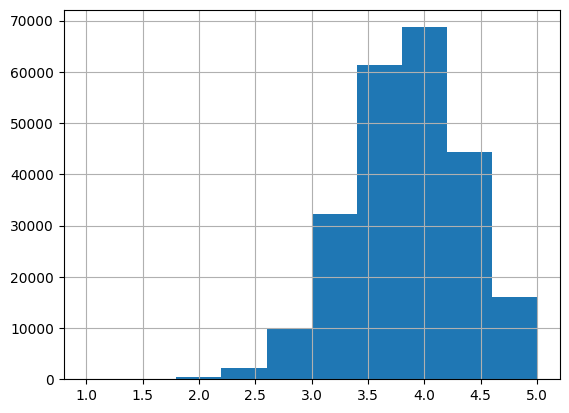

In [423]:
pred_df.Prediction_avg.hist()